<h1><b> NLP Model for Classifying Harmful Comments: A Case Study on YouTube Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
import torch
import re
from transformers import BertTokenizer, BertModel
import pandas as pd

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Masking, LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


custom_palette = ["#1f77b4", "#005a9e", "#003f7f"]
sns.set_theme(style="whitegrid", palette=custom_palette)

c:\Users\hilla\anaconda3\envs\deep-learning\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<h3><b> 1. Exploratory data analysis

In [2]:
# import dataset
df = pd.read_csv("YoutubeCommentsDataSet.csv")
df.head()

,Comment,Sentiment
0,lets not forget that apple pay in 2014 require...,neutral
1,here in nz 50 of retailers don’t even have con...,negative
2,i will forever acknowledge this channel with t...,positive
3,whenever i go to a place that doesn’t take app...,negative
4,apple pay is so convenient secure and easy to ...,positive


In [3]:
# Dataset structure
print("Dataset Info:\n")
df.info()

Dataset Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18408 entries, 0 to 18407
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Comment    18364 non-null  object
 1   Sentiment  18408 non-null  object
dtypes: object(2)
memory usage: 287.8+ KB


In [4]:
# Check missing values
df.isna().sum()
df.dropna(axis=0, inplace=True)
df.head()

,Comment,Sentiment
0,lets not forget that apple pay in 2014 require...,neutral
1,here in nz 50 of retailers don’t even have con...,negative
2,i will forever acknowledge this channel with t...,positive
3,whenever i go to a place that doesn’t take app...,negative
4,apple pay is so convenient secure and easy to ...,positive


In [5]:
# check sum of data in each sentiment class
df["Sentiment"].value_counts()

Sentiment
positive    11402
neutral      4625
negative     2337
Name: count, dtype: int64

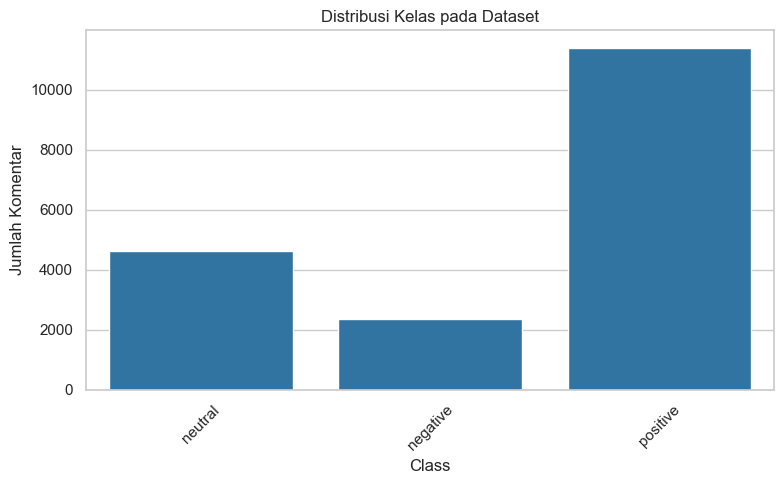

In [6]:
# Visualize sentiment class distribution
plt.figure(figsize=(8, 5))
class_column = 'class' if 'class' in df.columns else df.columns[-1] 

sns.countplot(data=df, x=class_column)
plt.title('Distribusi Kelas pada Dataset')
plt.xlabel('Class')
plt.ylabel('Jumlah Komentar')
plt.xticks(rotation=45)
plt.tight_layout() 
plt.show()

In [7]:
# Labeling sentiment by ordinal
le = LabelEncoder()
df["Sentiment"] = le.fit_transform(df["Sentiment"])

<h3><b> 2. Feature engineering

In [8]:
# Lowercasing comment and remove unusual text
def clean_text(text):
    # Ubah teks ke huruf kecil
    text = text.lower()                           

    # Hapus karakter non-ASCII (non-Inggris)
    text = re.sub(r'[^\x00-\x7F]+', '', text)  

    # Hapus karakter khusus (simbol atau angka saja)
    text = re.sub(r'^[^a-zA-Z]+$', '', text)  

    # Hapus karakter khusus dan angka yang berdiri sendiri
    text = re.sub(r'[^\w\s]', '', text)   

    # Hapus teks yang terlalu pendek (misalnya kosong atau hanya 1-2 karakter)
    if len(text.strip()) < 3:
        return np.nan  

    return text.strip()

In [9]:
df['cleaned_comment'] = df['Comment'].apply(clean_text)
df.shape

(18364, 3)

In [10]:
df.dropna(subset=['cleaned_comment'], inplace=True)
df.drop_duplicates(subset=['cleaned_comment'], inplace=True)
df.shape

(17609, 3)

In [11]:
# Text Vectorizer using BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

def bert_tokenizer(text):
    encoded_input = tokenizer(text, padding=True, truncation=True, return_tensors='pt', max_length=512)
    return encoded_input

def get_bert_embeddings(text):
    tokens = bert_tokenizer(text)
    with torch.no_grad():
        output = model(**tokens)
    return output.last_hidden_state[:, 0, :].squeeze().numpy()

X = np.array([get_bert_embeddings(comment) for comment in df['cleaned_comment']])

In [12]:
model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [13]:
y = df["Sentiment"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [14]:
# Smote sampling
smote = SMOTE(random_state=4, sampling_strategy='auto')
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
print("After SMOTE, X_train shape:", X_train_resampled.shape)

After SMOTE, X_train shape: (26403, 768)


C:\Users\hilla\AppData\Local\Temp\ipykernel_22172\1090244507.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_train_resampled, palette='magma')


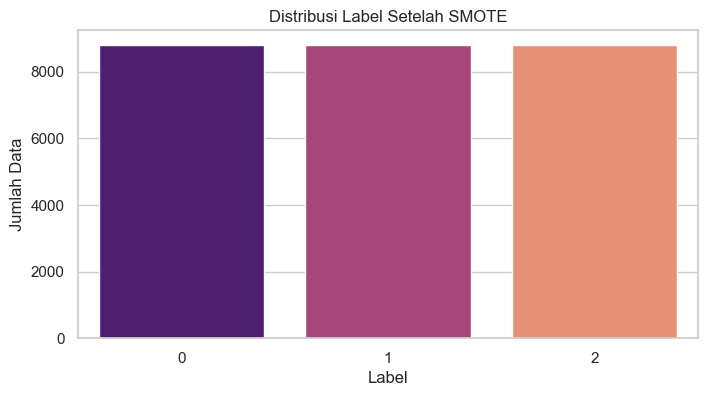

In [15]:
# Distribution after sampling
plt.figure(figsize=(8, 4))
sns.countplot(x=y_train_resampled, palette='magma')
plt.title('Distribusi Label Setelah SMOTE')
plt.xlabel('Label')
plt.ylabel('Jumlah Data')
plt.show()

In [16]:
# 6. Persiapkan Data untuk LSTM
X_train_resampled = X_train_resampled.reshape(X_train_resampled.shape[0], 1, X_train_resampled.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
print("X_train for LSTM shape:", X_train_resampled.shape)
print("X_test for LSTM shape:", X_test.shape)

X_train for LSTM shape: (26403, 1, 768)
X_test for LSTM shape: (3522, 1, 768)


In [17]:
model_lstm = Sequential()

model_lstm.add(Masking(mask_value=0.0, input_shape=(X_train_resampled.shape[1], X_train_resampled.shape[2])))

model_lstm.add(LSTM(128, return_sequences=True))
model_lstm.add(Dropout(0.2))

model_lstm.add(LSTM(64, return_sequences=True))
model_lstm.add(Dropout(0.1))

model_lstm.add(LSTM(32, return_sequences=True))
model_lstm.add(Dropout(0.2))

model_lstm.add(LSTM(16, return_sequences=False))
model_lstm.add(Dropout(0.2))


num_classes = len(np.unique(y))
model_lstm.add(Dense(num_classes, activation='softmax'))

model_lstm.compile(optimizer=Adam(learning_rate=0.0005), 
                   loss='sparse_categorical_crossentropy', 
                   metrics=['accuracy'])

model_lstm.summary()

c:\Users\hilla\anaconda3\envs\deep-learning\Lib\site-packages\keras\src\layers\core\masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking (Masking)               │ (None, 1, 768)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 1, 128)         │       459,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 1, 64)          │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 1, 32)          │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 524,275 (2.00 MB)

 Trainable params: 524,275 (2.00 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
history = model_lstm.fit(
    X_train_resampled, y_train_resampled,
    epochs=32,
    batch_size=8,
    validation_data=(X_test, y_test)
)

Epoch 1/32
3301/3301 ━━━━━━━━━━━━━━━━━━━━ 25s 5ms/step - accuracy: 0.6865 - loss: 0.7456 - val_accuracy: 0.7376 - val_loss: 0.6367
Epoch 2/32
3301/3301 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - accuracy: 0.7864 - loss: 0.5471 - val_accuracy: 0.7612 - val_loss: 0.5767
Epoch 3/32
3301/3301 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - accuracy: 0.8055 - loss: 0.4920 - val_accuracy: 0.7567 - val_loss: 0.5959
Epoch 4/32
3301/3301 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - accuracy: 0.8367 - loss: 0.4340 - val_accuracy: 0.7604 - val_loss: 0.5701
Epoch 5/32
3301/3301 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - accuracy: 0.8615 - loss: 0.3730 - val_accuracy: 0.7632 - val_loss: 0.5810
Epoch 6/32
3301/3301 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - accuracy: 0.8750 - loss: 0.3342 - val_accuracy: 0.7686 - val_loss: 0.6108
Epoch 7/32
3301/3301 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - accuracy: 0.8890 - loss: 0.3026 - val_accuracy: 0.7612 - val_loss: 0.6586
Epoch 8/32
3301/3301 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - accuracy: 0.9043 - loss: 0

In [19]:
y_pred = model_lstm.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
print("Classification Report:")
print(classification_report(y_test, y_pred_labels, target_names=le.classes_))

111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Classification Report:
              precision    recall  f1-score   support

    negative       0.64      0.59      0.61       463
     neutral       0.60      0.66      0.63       859
    positive       0.87      0.84      0.85      2200

    accuracy                           0.76      3522
   macro avg       0.70      0.70      0.70      3522
weighted avg       0.77      0.76      0.77      3522

